# 목표

Conv based로 D 모델만 학습이 가능한지 확인.

1. 가상의 G 모델(CLSTMC, pretrained)로 testset에 대해 prediction들을 생성
2. 생성한 데이터를 npy 파일로 저장
3. D 모델에서 가짜와 진짜 데이터를 구분이 가능한지(예측 데이터와 실제 데이터에 실제로 차이가 있는지) 를 확인한다.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
DATA_DIR = Path('data/1116')
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

print(len(ds_test))
print(ds_test[0][0].shape, ds_test[0][1].shape)

10671
torch.Size([120, 6]) torch.Size([120, 3])


torch.Size([120, 6]) torch.Size([120, 3])


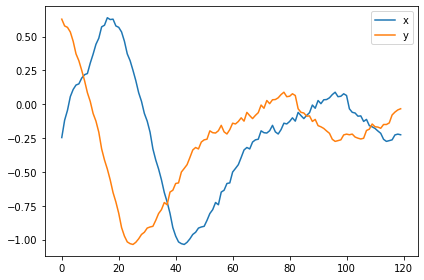

In [7]:
x, y = ds_test[0]
print(x.shape, y.shape)
plt.plot(x[:, 2])
plt.plot(y[:, 2])
plt.legend(['x', 'y'])
plt.tight_layout()
plt.show()

앞의 900ms 동안은 동일하고, 뒤의 300ms동안만 예측하면 된다.

# 모델 생성

In [8]:
class ResBlock1d(nn.Module):
    def __init__(self, inchannels, channels, kernel_size):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(inchannels, channels, 1),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

In [9]:
class CLSTMC(nn.Module):
    def __init__(self):
        super(CLSTMC, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(6, 24, 3, padding=1, groups=2),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Conv1d(24, 48, 3, padding=1, groups=2),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(),
            nn.Conv1d(48, 64, 3, padding=1),
            nn.BatchNorm1d(64),
        )

        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=64,
                           num_layers=6,
                           batch_first=True,
                           dropout=0,
                           bidirectional=True)

        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # B, S, 6 --> B, 6, S
        x = self.conv_in(x)  # B, 6, S
        x = x.transpose(1, 2)  # B, S, 6

        outs, (hiddens, cells) = self.rnn(x)  # B, S, 128
        x = outs.transpose(1, 2)  # B, 128, S
        x = self.conv_out(x) # (B, 3, S)
        x = x.transpose(1, 2) # (B, S, 3)

        return x

In [10]:
model = CLSTMC().cuda().eval()

In [11]:
torch.set_grad_enabled(False)

# Prediction

In [12]:
dl = DataLoader(ds_test, num_workers=16, shuffle=False, batch_size=1024)

In [13]:
preds = []
targets = []
inputs = []
for x, y in tqdm(dl, ncols=100, position=0):
    pred = model(x.cuda()).cpu()
    preds.append(pred)
    
    inputs.append(x)
    targets.append(y)

100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.96it/s]


In [14]:
pred = torch.cat(preds)
Y = torch.cat(targets)
X = torch.cat(inputs)
pred.shape, X.shape, Y.shape

(torch.Size([10671, 120, 3]),
 torch.Size([10671, 120, 6]),
 torch.Size([10671, 120, 3]))

In [15]:
Path('data/1130').mkdir(parents=True, exist_ok=True)

In [16]:
np.save('data/1130/X.npy', X.numpy())
np.save('data/1130/Y.npy', Y.numpy())
np.save('data/1130/pred.npy', pred.numpy())